# Eigenvalues of interval neutrino mixing matrices

The following notebook presents a method of bounding eigenvalues of interval neutrino mixing matrices by Rohn criterion (https://hal.inria.fr/inria-00370603/document).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wujekanimator/neutrino_matrices/blob/main/rohn_bounds.ipynb)

In [1]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#tqdm().pandas()
pd.set_option('display.max_colwidth', -1)

Let's define an auxiliary function, that takes (symmetric matrix) intervals and generates the eigenvalues of center matrix, spectrum of a delta matrix and Rohn bounds:

In [2]:
def interval_matrix_bounds(intervals):
    
    '''takes the interval matrix - intervals - and returns eigenvalues 
    of a symmetric center matrix and spectrum of a delta matrix, 
    together with intervals of allowed eigenvalues of the interval matrix'''
    
    dimension = int(np.sqrt(len(intervals)))
    
    a_c = [1/2*(interval[1]+interval[0]) for interval in intervals] # center matrix for each interval matrix
    a_c_T = np.transpose(np.reshape(a_c, (dimension,dimension))) # transpose the center matrix
    a_c_T = [item for sublist in a_c_T for item in sublist] # flatten nested a_c_T
    a_c_prime = [1/2*(x1+x2) for (x1,x2) in zip(a_c, a_c_T)] # make a symmetric center matrix
    
    eigs_a_c_prime = np.sort(np.abs(np.linalg.eigvals(np.reshape(a_c_prime,(dimension,dimension))))) # sorted eigenvalues
    
    a_delta = [1/2*(interval[1]-interval[0]) for interval in intervals] # delta matrix
    a_delta_T = np.transpose(np.reshape(a_delta, (dimension,dimension))) # transpose the delta matrix
    a_delta_T = [item for sublist in a_delta_T for item in sublist] # flatten
    a_delta_prime = [1/2*(x1+x2) for (x1,x2) in zip(a_delta, a_delta_T)] # symmetric delta matrix
    
    spec_a_delta_prime = max(np.abs(np.linalg.eigvals(np.reshape(a_delta_prime,(3,3))))) # spectral radius of a_delta_prime
    
    rohn_bounds = [[round(item - spec_a_delta_prime, 4), round(item + spec_a_delta_prime, 4)] for
                       item in eigs_a_c_prime]
    
    return eigs_a_c_prime, spec_a_delta_prime, rohn_bounds

Now we need the experimental mixing matrix; we use the $\eta$-representation (https://arxiv.org/pdf/1605.08774.pdf)

In [3]:
#intervals_eta = [[-0.0013, 0.0013], [-0.000012,0.000012], [-0.0014,0.0014],[-0.000012,0.000012], [-0.00022,0.00022], [-0.0006,0.0006],
#                  [-0.0014,0.0014], [-0.0006,0.0006], [-0.0028,0.0028]]
intervals_eta = [[-0.0014, 0.0014], [-0.000013,0.000013], [-0.0015,0.0015],[-0.000013,0.000013], [-0.00023,0.00023], [-0.0007,0.0007],
                  [-0.0015,0.0015], [-0.0007,0.0007], [-0.0029,0.0029]]

It follows that our matrix dimension will be

In [4]:
n = int(np.sqrt(len(intervals_eta)))

Now we define widths of intervals, that will be drawn from above - all widths are scaled to the precision of given element:

In [70]:
interval_widths = [0.0001, 0.000001, 0.0001, 0.000001, 0.00001, 0.0001,0.0001, 0.0001, 0.0001]
#interval_widths = [0.002, 0.00002, 0.002, 0.00002, 0.0002, 0.002,0.002, 0.002, 0.002]
#interval_widths = [0.005, 0.00005, 0.005, 0.00005, 0.0005, 0.005,0.005, 0.005, 0.005]
#interval_widths = [0.1, 0.001, 0.1, 0.001, 0.01, 0.1,0.1, 0.1, 0.1]

We need to subtract ```intervals_eta``` from an identity, hence

In [71]:
double_identity = [[item,item] for item in np.identity(n).flatten()]
intervals_1_eta = double_identity + np.array(intervals_eta)
intervals_1_eta = [[item[1],item[0]] for item in intervals_1_eta]

In [72]:
interval_matrix_bounds(intervals_1_eta)

(array([1., 1., 1.]),
 0.003926183259609953,
 [[0.9961, 1.0039], [0.9961, 1.0039], [0.9961, 1.0039]])

Now we prepare lists for: 1) eigenvalues of center matrices $M_C$, 2) spectra of delta-matrices $M_{\Delta}$, 3) allowed intervals of eigenvalues and finally 4) drawn intervals:

In [73]:
a_c_all_eigs = []
spectra = []
rohn_bounds = []
intervals = [] 

Let's decide on how many matrices will be drawn:

In [101]:
range_i = 1000

Now we draw ```range_i```-many interval matrices, for each matrix we calculate the eigenvalues (Rohn) bounds

In [102]:
for i in tqdm(range(1,range_i)):
    # first we randomly pick narrow bounds for interval matrix
    bounds = []
    # indices for making a symmetric interval matrix
    indices = [0,1,2,1,3,4,2,4,5]
    i=0
    for item in intervals_1_eta:
        bound = np.random.uniform(low=item[0], high=item[1])
        bounds.append([bound, bound + interval_widths[i]])
        i+=1
    
    bounds = [bounds[i] for i in indices]
    intervals.append(bounds)
    a_c_all_eigs.append(np.abs(interval_matrix_bounds(bounds)[0]))
    spectra.append(interval_matrix_bounds(bounds)[1])
    rohn_bounds.append(interval_matrix_bounds(bounds)[2])

100%|██████████| 999/999 [00:00<00:00, 1190.56it/s]


We form a dataframes of center matrix eigenvalues and Rohn bounds from above loop:

In [103]:
a_c_all_eigs_df = pd.DataFrame(a_c_all_eigs, columns=['eigenvalue_1',
                                                      'eigenvalue_2',
                                                      'eigenvalue_3'])
rohn_bounds_df = pd.DataFrame(rohn_bounds, columns=['interval_1',
                                                    'interval_2',
                                                    'interval_3'])

Let's add also the column with an explicit matrix elements:

In [104]:
rohn_bounds_df['matrix'] = [[[round(item,4) for item in item2] for item2 in item3] for item3 in intervals]
rohn_bounds_df

,interval_1,interval_2,interval_3,matrix
0,"[0.9991, 0.9993]","[1.0002, 1.0004]","[1.0004, 1.0006]","[[1.0, 1.0001], [0.0, 0.0], [-0.0009, -0.0008], [0.0, 0.0], [-0.0, -0.0], [1.0, 1.0], [-0.0009, -0.0008], [1.0, 1.0], [-0.0006, -0.0005]]"
1,"[0.9994, 0.9996]","[0.9998, 1.0]","[1.0012, 1.0014]","[[1.0005, 1.0006], [-0.0, -0.0], [-0.0013, -0.0012], [-0.0, -0.0], [-0.0, -0.0], [1.0001, 1.0001], [-0.0013, -0.0012], [1.0001, 1.0001], [0.0003, 0.0004]]"
2,"[0.9989, 0.9991]","[1.0, 1.0002]","[1.0002, 1.0004]","[[0.999, 0.9991], [-0.0, -0.0], [-0.0002, -0.0001], [-0.0, -0.0], [0.0, 0.0], [1.0002, 1.0002], [-0.0002, -0.0001], [1.0002, 1.0002], [-0.0002, -0.0001]]"
3,"[0.999, 0.9992]","[0.9995, 0.9997]","[1.0006, 1.0008]","[[0.9995, 0.9996], [0.0, 0.0], [-0.0011, -0.001], [0.0, 0.0], [-0.0, 0.0], [0.9999, 0.9999], [-0.0011, -0.001], [0.9999, 0.9999], [0.0006, 0.0007]]"
4,"[0.9994, 0.9996]","[1.0003, 1.0005]","[1.0016, 1.0018]","[[1.0012, 1.0013], [-0.0, -0.0], [0.0012, 0.0013], [-0.0, -0.0], [0.0, 0.0], [1.0002, 1.0002], [0.0012, 0.0013], [1.0002, 1.0002], [-0.0005, -0.0004]]"
...,...,...,...,...
110992,"[0.9996, 0.9998]","[0.9997, 0.9999]","[1.0018, 1.002]","[[1.0014, 1.0015], [0.0, 0.0], [-0.0013, -0.0012], [0.0, 0.0], [-0.0, -0.0], [1.0, 1.0], [-0.0013, -0.0012], [1.0, 1.0], [0.0004, 0.0005]]"
110993,"[0.9992, 0.9994]","[0.9999, 1.0001]","[1.0002, 1.0004]","[[1.0001, 1.0002], [-0.0, -0.0], [-0.0006, -0.0005], [-0.0, -0.0], [-0.0, -0.0], [0.9998, 0.9998], [-0.0006, -0.0005], [0.9998, 0.9998], [-0.0005, -0.0004]]"
110994,"[0.9983, 0.9985]","[0.9997, 0.9999]","[1.0, 1.0002]","[[0.9987, 0.9988], [0.0, 0.0], [0.0008, 0.0009], [0.0, 0.0], [-0.0, -0.0], [0.9998, 0.9998], [0.0008, 0.0009], [0.9998, 0.9998], [-0.0007, -0.0006]]"
110995,"[0.9994, 0.9996]","[1.0002, 1.0004]","[1.0006, 1.0008]","[[1.0001, 1.0002], [-0.0, -0.0], [-0.0009, -0.0008], [-0.0, -0.0], [-0.0, -0.0], [1.0002, 1.0002], [-0.0009, -0.0008], [1.0002, 1.0002], [-0.0003, -0.0002]]"


In [105]:
rohn_bounds_df[['interval_31','interval_32']] = pd.DataFrame(rohn_bounds_df.interval_3.tolist(), index= rohn_bounds_df.index)
rohn_bounds_df[['interval_11','interval_12']] = pd.DataFrame(rohn_bounds_df.interval_1.tolist(), index= rohn_bounds_df.index)

In [106]:
rohn_bounds_df.loc[rohn_bounds_df['interval_31'] > 1.003]
rohn_bounds_df.loc[rohn_bounds_df['interval_12'] < 0.998]

,interval_1,interval_2,interval_3,matrix,interval_31,interval_32,interval_11,interval_12


We take a look at the histogram of eigenvalues of center matrices:

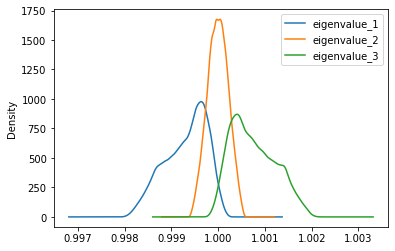

In [107]:
a_c_all_eigs_df.plot.kde()
#plt.savefig('kde5.pdf')

Next we check the scenarios.
* find non-contractions

In [110]:
a_c_all_eigs_df

,eigenvalue_1,eigenvalue_2,eigenvalue_3
0,0.999233,1.000260,1.000466
1,0.999479,0.999895,1.001314
2,0.999036,1.000096,1.000275
3,0.999064,0.999567,1.000651
4,0.999536,1.000423,1.001657
...,...,...,...
110992,0.999708,0.999750,1.001921
110993,0.999333,1.000015,1.000330
110994,0.998368,0.999825,1.000132
110995,0.999465,1.000278,1.000722


In [119]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
fig = plotly.express.scatter_3d(a_c_all_eigs_df)
fig.show()